<a href="https://colab.research.google.com/github/bsaha205/Fall_22_PML/blob/main/PML_HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1



**Framework:** Pytorch

**Dataset:** FashionMNIST from torchvision.datasets (https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).

**Resources:**
1. Optimizer: I used Adam optimizer from torch.optim (https://pytorch.org/docs/stable/optim.html).
2. MLP: Used torch.nn for implementing 2-layer NN model (https://pytorch.org/docs/stable/nn.html).
3. Plot: For plotting the data, I used matplotlib.pyplot library (https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.html).
4. Loss function: For loss function, I used cross_entropy loss from F.cross_entropy (https://pytorch.org/docs/stable/nn.functional.html).
5. Class Identify: To identify right class, I used log_softmax from F.log_softmax (https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html).

# Task 2

## Exploratory Data Analysis

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import joblib
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [ ]:
# read FashionMNIST data from torchvision.datasets
train_data = datasets.FashionMNIST('.', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_data = datasets.FashionMNIST('.', train=False, transform=transforms.Compose([transforms.ToTensor()]))

# print the shape of the dataset
print("train images:", train_data.data.size())
print("test images:", test_data.data.size())

train images: torch.Size([60000, 28, 28])
test images: torch.Size([10000, 28, 28])


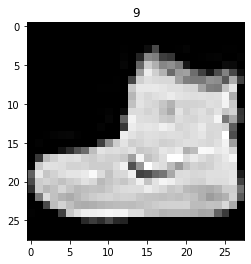

In [ ]:
# plot the very first image of train dataset with label
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

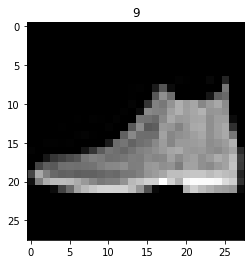

In [ ]:
# plot the very first image of test dataset with label
plt.imshow(test_data.data[0].numpy(), cmap='gray')
plt.title('%i' % test_data.targets[0])
plt.show()

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        '''in_dim: input layer dim
           hidden_dim: hidden layer dim
           out_dim: output layer dim'''
        
        super(MLP, self).__init__()
        
        # images are 28x28 so we need to flatten them into 784d vector
        self.flatten = nn.Flatten()
        
        # #two fully connected layers
        # self.fc1 = nn.Linear(in_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, out_dim)
        
        #three fully connected layers
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 256)
        self.fc3 = nn.Linear(256, out_dim)

    def forward(self, x):
        # x is 28x28, flatten it first
        x = self.flatten(x)
        
        # compute output of fc1 and then apply relu activation
        x = F.relu(self.fc1(x))

        # # for 2 layers
        # # compute output layer, no activation needed, cross entropy will compute softmax
        # x = self.fc2(x)

        # for 3 layers
        # compute output of fc2 and then apply relu activation
        x = F.relu(self.fc2(x))
        # compute output layer, no activation needed, cross entropy will compute softmax
        x = self.fc3(x)
        
        return x

## Training

In [ ]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

#hyper-paramets defining
batch_size = 1000
learning_rate = 0.01
epochs = 10
in_dim = 28 # images are 28x28 as inputs
hidden_dim = 512 # 512d hidden layer
number_of_class = 10 # output is 10d since there are 10 classes

# set model
model = MLP(in_dim*in_dim, hidden_dim, number_of_class)

# optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# load training data in batches
train_loader = du.DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             shuffle=True)
# send model over to device
model = model.to(device)
model.train()

using device: cpu


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

Training loop over batches

In [ ]:
for epoch in range(1, epochs + 1):    
    sum_valid_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):

        # send batch over to device
        data, target = data.to(device), target.to(device)
        
        # zero out prev gradients
        optimizer.zero_grad()
        
        # run the forward pass
        output = model(data)
        
        # compute loss/error
        loss = F.cross_entropy(output, target)

        # I used first 50000 datapoints of train_data as trainig dataset and last 10000 points as validation dataset
        if batch_idx >= 50:
          # sum up batch losses for validation dataset
          sum_valid_loss += loss.item()
          continue
        
        # compute gradients and take a step in training phase
        loss.backward()
        optimizer.step()
        
    # average loss per example    
    sum_valid_loss /= 10000
    print(f'Epoch: {epoch}, Validation Loss: {sum_valid_loss:.6f}')

Epoch: 1, Validation Loss: 0.000454
Epoch: 2, Validation Loss: 0.000375
Epoch: 3, Validation Loss: 0.000356
Epoch: 4, Validation Loss: 0.000319
Epoch: 5, Validation Loss: 0.000308
Epoch: 6, Validation Loss: 0.000298
Epoch: 7, Validation Loss: 0.000307
Epoch: 8, Validation Loss: 0.000307
Epoch: 9, Validation Loss: 0.000270
Epoch: 10, Validation Loss: 0.000264


## Testing

In [ ]:
# load test images in batches
test_loader = du.DataLoader(dataset=test_data,
                            batch_size=batch_size,
                            shuffle=True)

# set model in eval mode as we are no longer training
model.eval()
test_loss = 0
correct = 0

# turning of gradient computation that will speed up testing
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # send batches to device
        data, target = data.to(device), target.to(device)
        
        # compute forward pass and loss
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        # sum up batch loss
        test_loss += loss.item()

        # get the class of the max log-probability
        output = F.log_softmax(output, dim=1)
        pred = output.max(dim=1)[1]

        # add up number of correct predictions
        correct += torch.sum(pred == target)
  
    # test loss per example
    test_loss /= len(test_loader.dataset)
    
    # final test accuracy
    test_acc = correct / len(test_loader.dataset)
    print(f'Test loss: {test_loss:.6f}, accuracy: {test_acc:.4f}', f'correct: {correct}')

Test loss: 0.000346, accuracy: 0.8784 correct: 8784


# Task 3

Hyperparameters Used:
1. batch_size - tried values (512, 1000, 1024)
2. learning rate - tried values (0.1, 0.01, 0.001)
3. epochs - tried values (5, 10)
4. hidden_dim - tried values (256, 512)
5. layer - tried values (2, 3, 4)

Some best configs:
1. learning rate (0.01), layer (2), epoch (5) - accuracy (0.8646)
2. learning rate (0.001), layer (2), epoch (10) - accuracy (0.8625)
3. learning rate (0.1), layer (2), epoch (10) - accuracy (0.8109)
4. learning rate (0.01), layer (3), epoch (10) - accuracy (**0.8784**)

I used different configurations of hyperparametes to get the best test accuracy. From the above some different configurations, we can see the test accuracy is the highest for learning rate 0.01 and layer 3. 

I did not use regularization, as I saw the dataset does not contain either of high bias or high variance rather the bias and variance are low. Also, the model is not actually overfitting for these small number of layers. Hence, use of regularization technic would not create big difference in this case (although the accuracy might improve in a bit). 

Yes, I used Adam optimization algorithm from torch.optim (https://pytorch.org/docs/stable/optim.html). Without optimizing, the model would not converge fast and hence it would perform very poor for this MLP network.

# Task 4

Decision Tree Classifier Implementation

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import tree

# reshape 28x28 images to 784d vector
train_data.data = torch.reshape(train_data.data, (60000, 784))
test_data.data = torch.reshape(test_data.data, (10000, 784))

criterion_list = ['gini', 'entropy']
max_depth_list = [32, 64]
min_samples_split_list = [16, 32]
max_features_list = [64, 128, 256, 512]

iter = 1
optimum_criterion = None
optimum_max_depth = None
optimum_min_samples_split = None
optimum_max_features = None
max_accuracy_score = 0
for criterion in criterion_list:
  for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
      for max_features in max_features_list:
        print('iter:', iter, ', criterion:', criterion, ', max_depth:', max_depth, ', min_samples_split:', min_samples_split, ', max_features:', max_features)
        # Initialize our decision tree object
        classification_tree = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, max_features=max_features)

        # Train our decision tree (tree induction + pruning)
        classification_tree = classification_tree.fit(train_data.data, train_data.targets)

        # Predict
        y_pred = classification_tree.predict(test_data.data, check_input=True)
        accu_score = accuracy_score(y_pred, test_data.targets)
        print("accu_score: %.4f" % (accu_score))
        
        if accu_score > max_accuracy_score:
          max_accuracy_score = accu_score
          optimum_criterion = criterion
          optimum_max_depth = max_depth
          optimum_min_samples_split = min_samples_split
          optimum_max_features = max_features

        iter += 1

print('---------------Optimum results and configurations---------------')
print("max_accuracy_score: %.4f" % (max_accuracy_score))
print('optimum_criterion:', optimum_criterion, ', optimum_max_depth:', optimum_max_depth, ', optimum_min_samples_split:', optimum_min_samples_split, ', optimum_max_features:', optimum_max_features)

iter: 1 , criterion: gini , max_depth: 32 , min_samples_split: 16 , max_features: 64
accu_score: 0.7882
iter: 2 , criterion: gini , max_depth: 32 , min_samples_split: 16 , max_features: 128
accu_score: 0.7937
iter: 3 , criterion: gini , max_depth: 32 , min_samples_split: 16 , max_features: 256
accu_score: 0.7956
iter: 4 , criterion: gini , max_depth: 32 , min_samples_split: 16 , max_features: 512
accu_score: 0.7999
iter: 5 , criterion: gini , max_depth: 32 , min_samples_split: 32 , max_features: 64
accu_score: 0.7884
iter: 6 , criterion: gini , max_depth: 32 , min_samples_split: 32 , max_features: 128
accu_score: 0.7959
iter: 7 , criterion: gini , max_depth: 32 , min_samples_split: 32 , max_features: 256
accu_score: 0.7941
iter: 8 , criterion: gini , max_depth: 32 , min_samples_split: 32 , max_features: 512
accu_score: 0.7971
iter: 9 , criterion: gini , max_depth: 64 , min_samples_split: 16 , max_features: 64
accu_score: 0.7898
iter: 10 , criterion: gini , max_depth: 64 , min_samples_s

I tried Decision Tree Classifier as the other baseline method from scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and tried different configurations of hyper-parameter, printed with test accuracy above. I got the best test accuracy of 0.8100 for the criterion: entropy, max_depth: 64, min_samples_split: 32 and max_features: 512. 


Best test accuracy for MLP: 0.8784

Best test accuracy for Decision Tree: 0.8100

From the above results, we can see 3-layer MLP works better than Decision Tree for this FashionMNIST dataset. The reason is that FashionMNIST is a large dataset with 60000 datapoints, 784 (28x28) features and 10 classes. Being a baseline model, Decision Tree works well for the small number of datasets with small features and classes. Here MLP wins over Decision Tree classifier.